In [56]:
import cv2
import numpy as np

from pathlib import Path
from google.colab import files

import io
from collections import deque

from PIL import Image
import matplotlib.pyplot as plt

In [155]:
IMG_PATH = '/content/image1.jpg'

In [156]:
img = cv2.imread(IMG_PATH)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

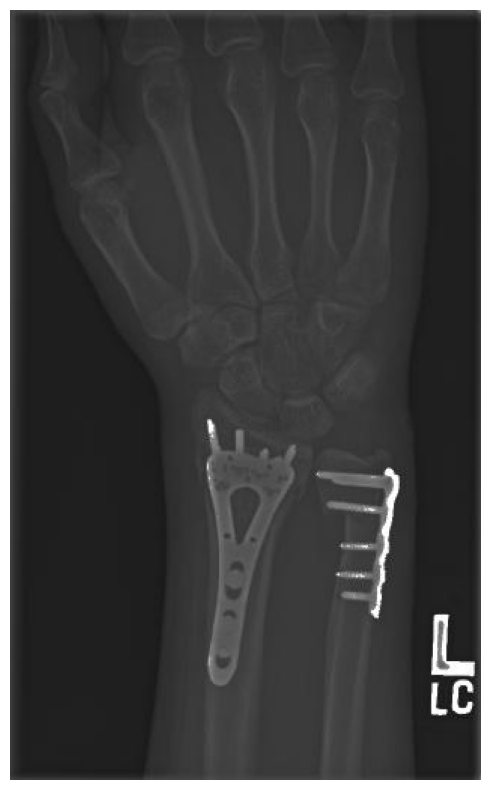

In [157]:
plt.figure(figsize=[10, 10])
plt.axis('off')
plt.imshow(img)

### 1. Методы глобальной и адаптивной бинаризации

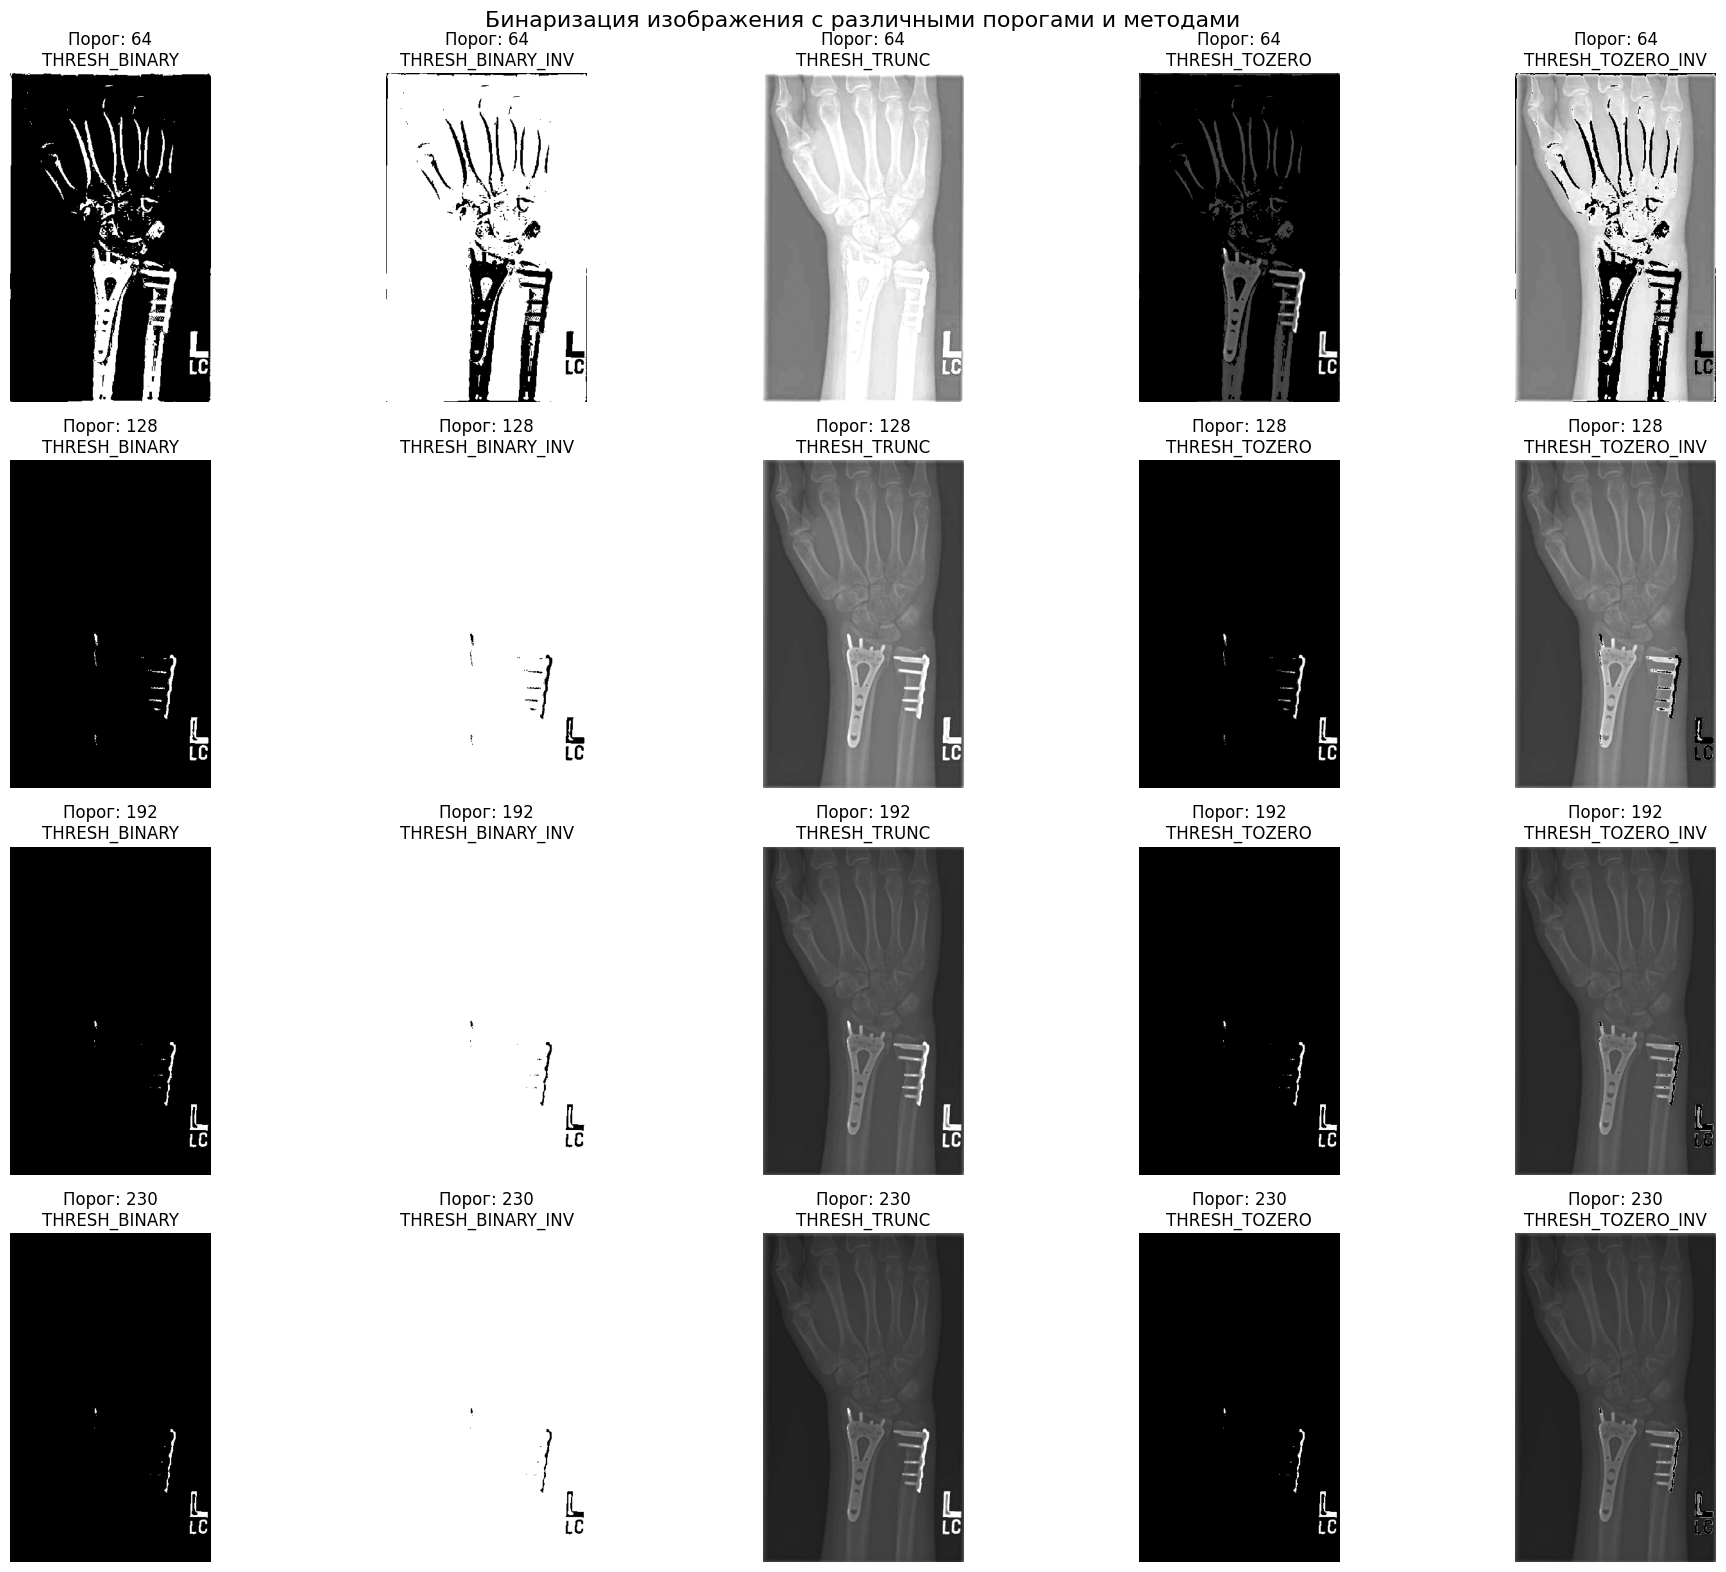

In [158]:
# Ручной подбор порога (cv2.threshold с cv2.THRESH_BINARY и cv2.THRESH_BINARY_INV)

thresholds = [64, 128, 192, 230]

# Список методов бинаризации (кортежи: (код, название))
methods = [
    (cv2.THRESH_BINARY, 'THRESH_BINARY'),
    (cv2.THRESH_BINARY_INV, 'THRESH_BINARY_INV'),
    (cv2.THRESH_TRUNC, 'THRESH_TRUNC'),
    (cv2.THRESH_TOZERO, 'THRESH_TOZERO'),
    (cv2.THRESH_TOZERO_INV, 'THRESH_TOZERO_INV')
]

# Создаем фигуру с subplot'ами
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Бинаризация изображения с различными порогами и методами', fontsize=16)

# Двойной цикл по строкам (пороги) и столбцам (методы)
for i, thresh_val in enumerate(thresholds):  # строки - пороги
    for j, (method_code, method_name) in enumerate(methods):  # столбцы - методы
        # Применяем бинаризацию
        ret, th_img = cv2.threshold(gray, thresh_val, 255, method_code)

        # Отображаем изображение
        axes[i, j].imshow(th_img, cmap='gray')
        axes[i, j].set_title(f'Порог: {thresh_val}\n{method_name}')
        axes[i, j].axis('off')

# Настраиваем отступы между subplot'ами
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

In [159]:
# Автоматический подбор порога методом Оцу (cv2.THRESH_OTSU)

ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print('Оптимальный порог бинаризации по Отсу: ', ret)

Оптимальный порог бинаризации по Отсу:  137.0


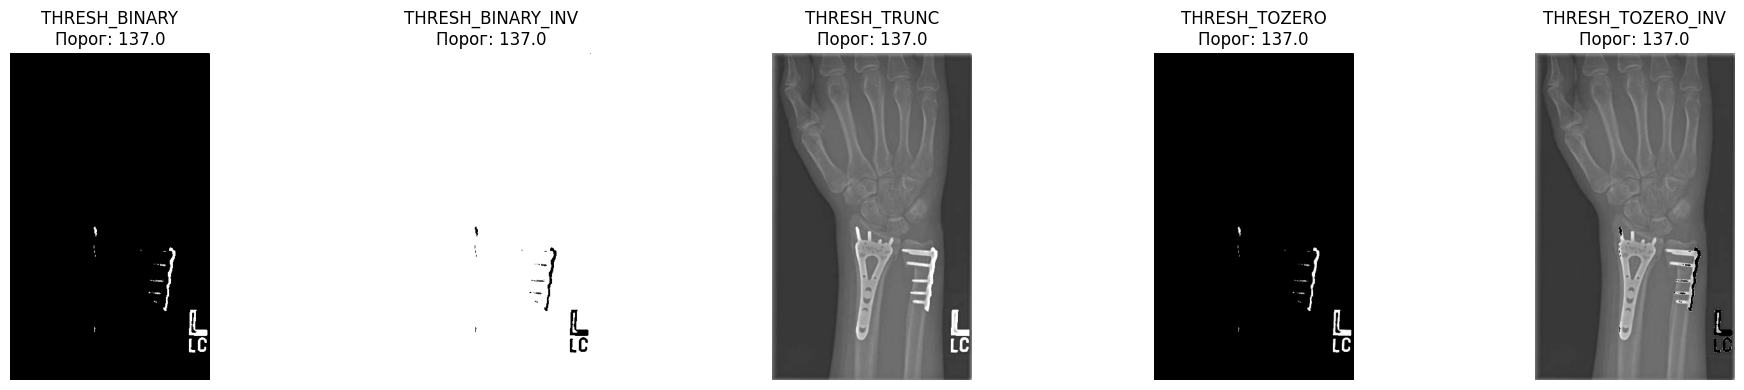

In [160]:
# Список методов бинаризации
methods = [
    (cv2.THRESH_BINARY, 'THRESH_BINARY'),
    (cv2.THRESH_BINARY_INV, 'THRESH_BINARY_INV'),
    (cv2.THRESH_TRUNC, 'THRESH_TRUNC'),
    (cv2.THRESH_TOZERO, 'THRESH_TOZERO'),
    (cv2.THRESH_TOZERO_INV, 'THRESH_TOZERO_INV')
]

# Применяем метод Оцу для определения порога
ret_otsu, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))


for j, (method_code, method_name) in enumerate(methods):
    # Применяем бинаризацию с порогом Отсу
    ret, th_img = cv2.threshold(gray, ret_otsu, 255, method_code)

    # Отображаем изображение
    axes[j].imshow(th_img, cmap='gray')
    axes[j].set_title(f'{method_name}\nПорог: {ret_otsu:.1f}')
    axes[j].axis('off')

plt.tight_layout()
plt.show()

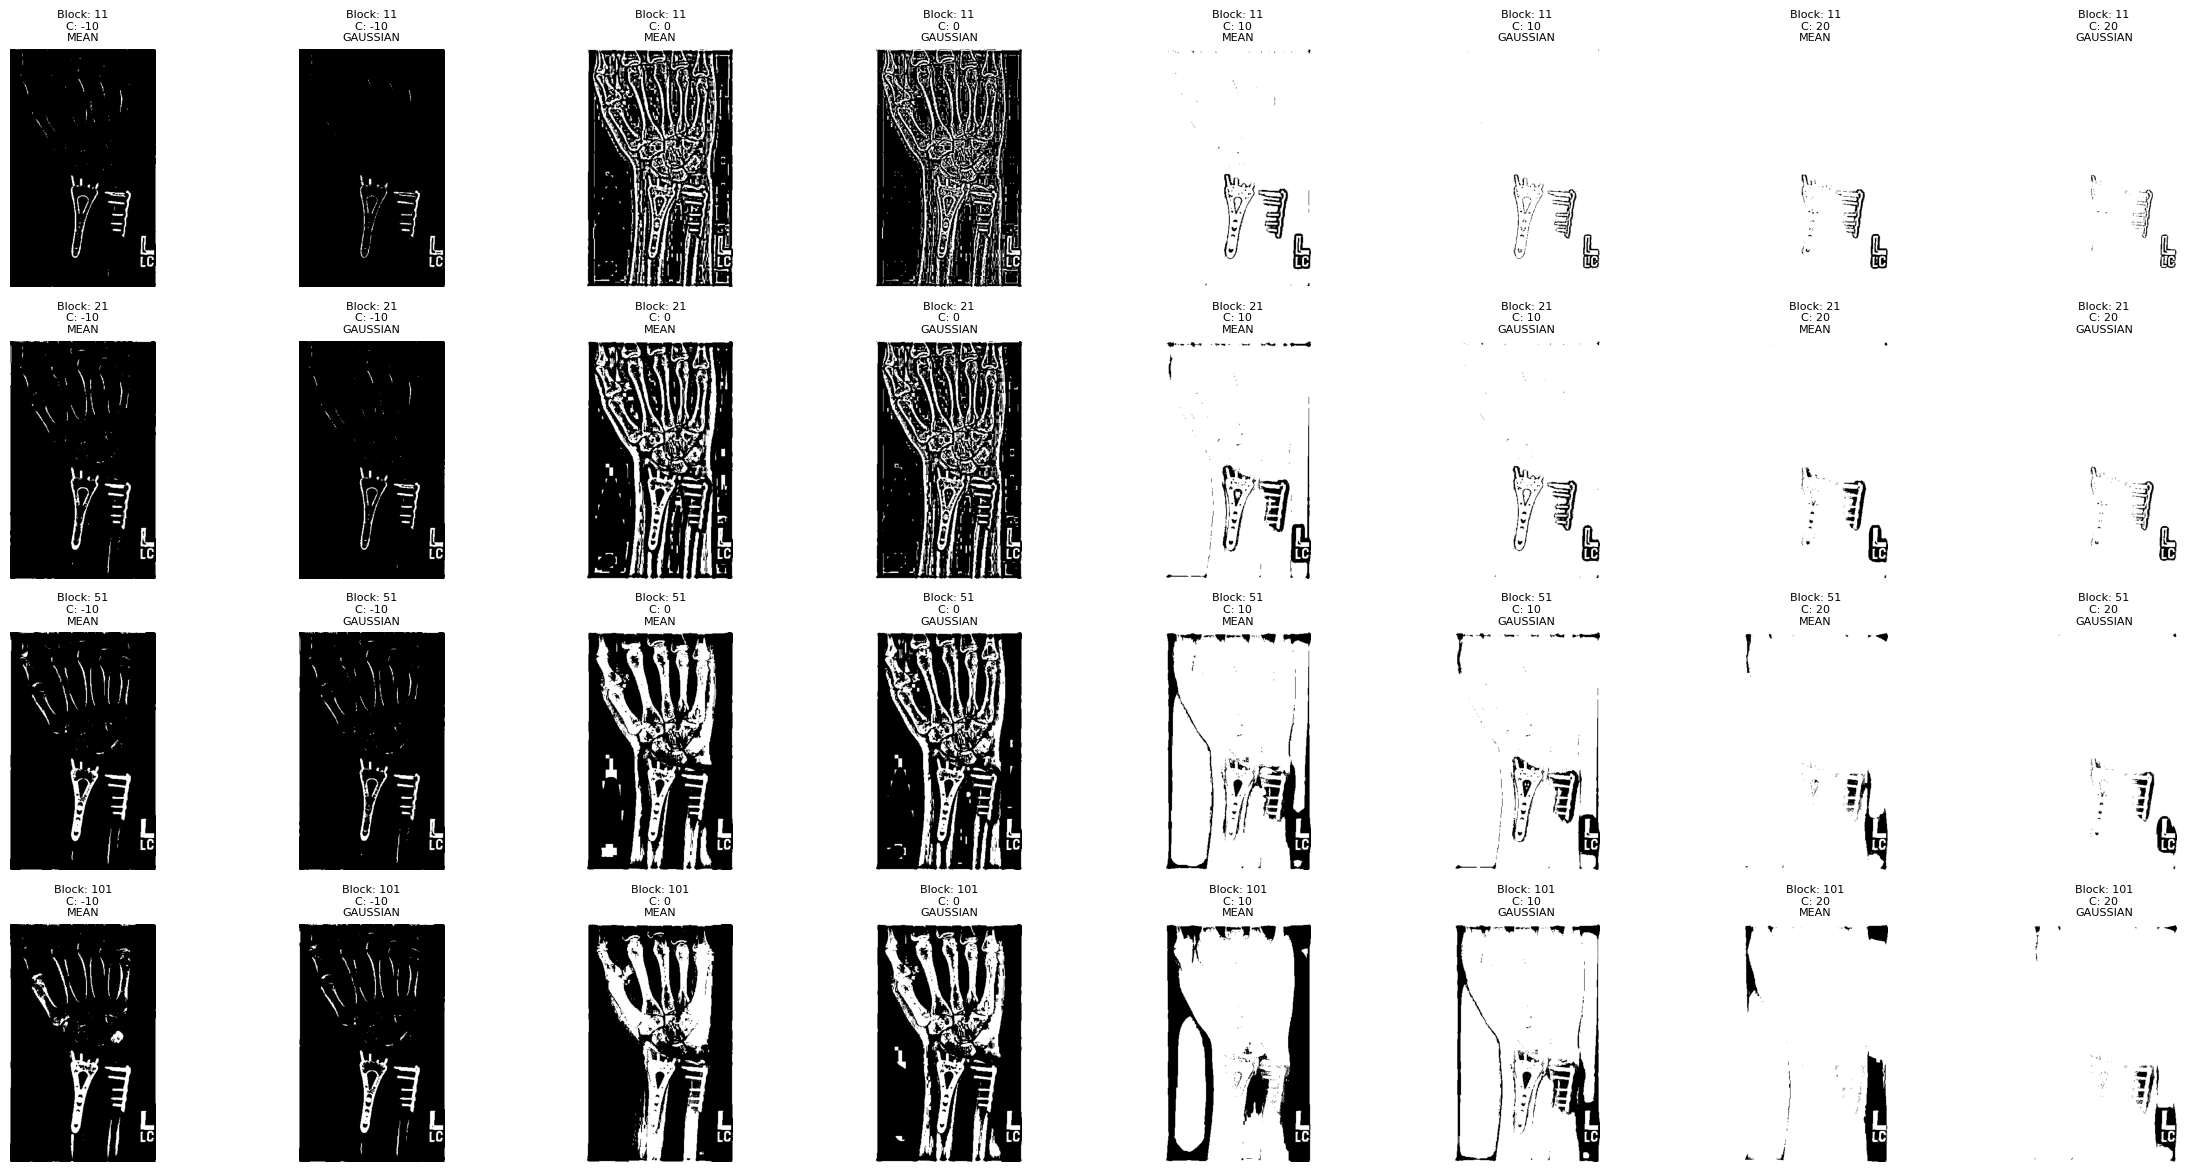

In [161]:
# Адаптивная бинаризация с использованием среднего (cv2.ADAPTIVE_THRESH_MEAN_C) и гауссова (cv2.ADAPTIVE_THRESH_GAUSSIAN_C) порогов

adaptive_methods = [
    (cv2.ADAPTIVE_THRESH_MEAN_C, 'MEAN'),
    (cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 'GAUSSIAN')
]

threshold_types = [
    (cv2.THRESH_BINARY, 'BINARY'),
    (cv2.THRESH_BINARY_INV, 'BINARY_INV')
]

block_sizes = [11, 21, 51, 101]
constants = [-10, 0, 10, 20]

fig, axes = plt.subplots(4, 8, figsize=(24, 12))


for i, block_size in enumerate(block_sizes):
    for j, constant in enumerate(constants):
        for k, (adaptive_method, method_name) in enumerate(adaptive_methods):
            # Вычисляем позицию в сетке
            col_idx = j * 2 + k

            # Применяем адаптивную бинаризацию
            th_adaptive = cv2.adaptiveThreshold(
                gray,
                255,
                adaptive_method,
                cv2.THRESH_BINARY,
                block_size,
                constant
            )

            # Отображаем результат
            axes[i, col_idx].imshow(th_adaptive, cmap='gray')
            axes[i, col_idx].set_title(f'Block: {block_size}\nC: {constant}\n{method_name}',
                                     fontsize=8)
            axes[i, col_idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

### 2. Методы сегментации изображений

In [57]:
# Region Growing
def region_growing(gray, seed_points, threshold=10, connectivity=8):

    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

    # Инициализируем маску результата
    segmented = np.zeros_like(gray, dtype=np.uint8)
    visited = np.zeros_like(gray, dtype=bool)

    # Определяем соседей
    if connectivity == 4:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectivity == 8:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, -1), (-1, 1), (1, -1), (1, 1)]
    else:
        raise ValueError("Connectivity must be 4 or 8")

    # Обрабатываем каждую затравочную точку
    for seed in seed_points:
        y_seed, x_seed = seed

        if not (0 <= y_seed < gray.shape[0] and 0 <= x_seed < gray.shape[1]):
            print(f"Предупреждение: затравочная точка {seed} вне границ изображения")
            continue

        queue = deque([(y_seed, x_seed)])
        seed_intensity = gray[y_seed, x_seed]
        visited[y_seed, x_seed] = True
        segmented[y_seed, x_seed] = 255

        while queue:
            y, x = queue.popleft()

            for dy, dx in neighbors:
                ny, nx = y + dy, x + dx

                if (0 <= ny < gray.shape[0] and 0 <= nx < gray.shape[1]
                    and not visited[ny, nx]):

                    if abs(int(gray[ny, nx]) - int(seed_intensity)) <= threshold:
                        segmented[ny, nx] = 255
                        visited[ny, nx] = True
                        queue.append((ny, nx))

    return segmented

In [58]:
def upload_image():

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f'Загружено: {filename}')

        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            image = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return gray, image
    return None, None

In [62]:
def select_seed_points_matplotlib(gray):

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(gray, cmap='gray')

    seed_points = []

    def onclick(event):
        if event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            seed_points.append((y, x))
            ax.plot(x, y, 'ro', markersize=5)
            fig.canvas.draw()
            print(f'Добавлена точка: ({y}, {x})')

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.axis('off')
    plt.show()

    return seed_points

In [63]:
def demonstrate_region_growing():

    # 1. Загрузка изображения
    gray, color_image = upload_image()


    # 2. Выбор затравочных точек
    seed_points = select_seed_points_matplotlib(gray)

    if not seed_points:
        h, w = gray.shape
        seed_points = [(h//2, w//2)]
        print(f"Автоматически выбрана точка: {seed_points[0]}")

    # 3. Параметры сегментации
    threshold = 20
    connectivity = 8

    print(f"Порог: {threshold}")
    print(f"Связность: {connectivity}")
    print(f"Затравочные точки: {seed_points}")

    # 4. Выполнение сегментации
    result = region_growing(gray, seed_points, threshold, connectivity)

    # 5. Визуализация результатов
    print("\n5. Визуализация результатов")

    # Создаём визуализацию с выделенными областями
    visualization = color_image.copy()
    visualization[result == 255] = [0, 255, 0]  # Зелёный цвет для выделенной области

    # Отмечаем затравочные точки
    for y, x in seed_points:
        cv2.circle(visualization, (x, y), 5, (255, 0, 0), -1)  # Красные точки

    # Отображаем результаты
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Исходное изображение
    axes[0, 0].imshow(gray, cmap='gray')
    axes[0, 0].set_title('Исходное изображение')
    axes[0, 0].axis('off')

    # Маска сегментации
    axes[0, 1].imshow(result, cmap='gray')
    axes[0, 1].set_title('Маска сегментации')
    axes[0, 1].axis('off')

    # Визуализация с наложением
    axes[1, 0].imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('Результат сегментации')
    axes[1, 0].axis('off')

    # Комбинированное изображение
    axes[1, 1].imshow(gray, cmap='gray')
    axes[1, 1].imshow(result, alpha=0.3, cmap='Reds')
    axes[1, 1].set_title('Наложение маски')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Статистика
    area = np.sum(result == 255)
    print(f"\nСтатистика:")
    print(f"Площадь сегментированной области: {area} пикселей")
    print(f"Процент от всего изображения: {area / (gray.shape[0] * gray.shape[1]) * 100:.2f}%")

    return result, seed_points

=== Region Growing Demo в Google Colab ===

1. Загрузка изображения...


Saving image1.jpg to image1 (3).jpg
Загружено: image1 (3).jpg


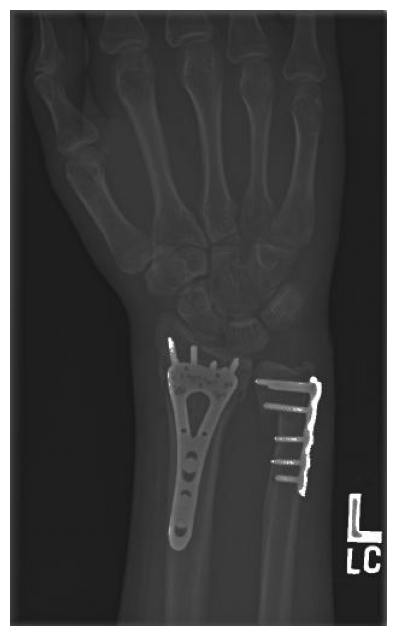

Автоматически выбрана точка: (256, 156)

3. Параметры
Порог: 20
Связность: 8
Затравочные точки: [(256, 156)]

5. Визуализация результатов


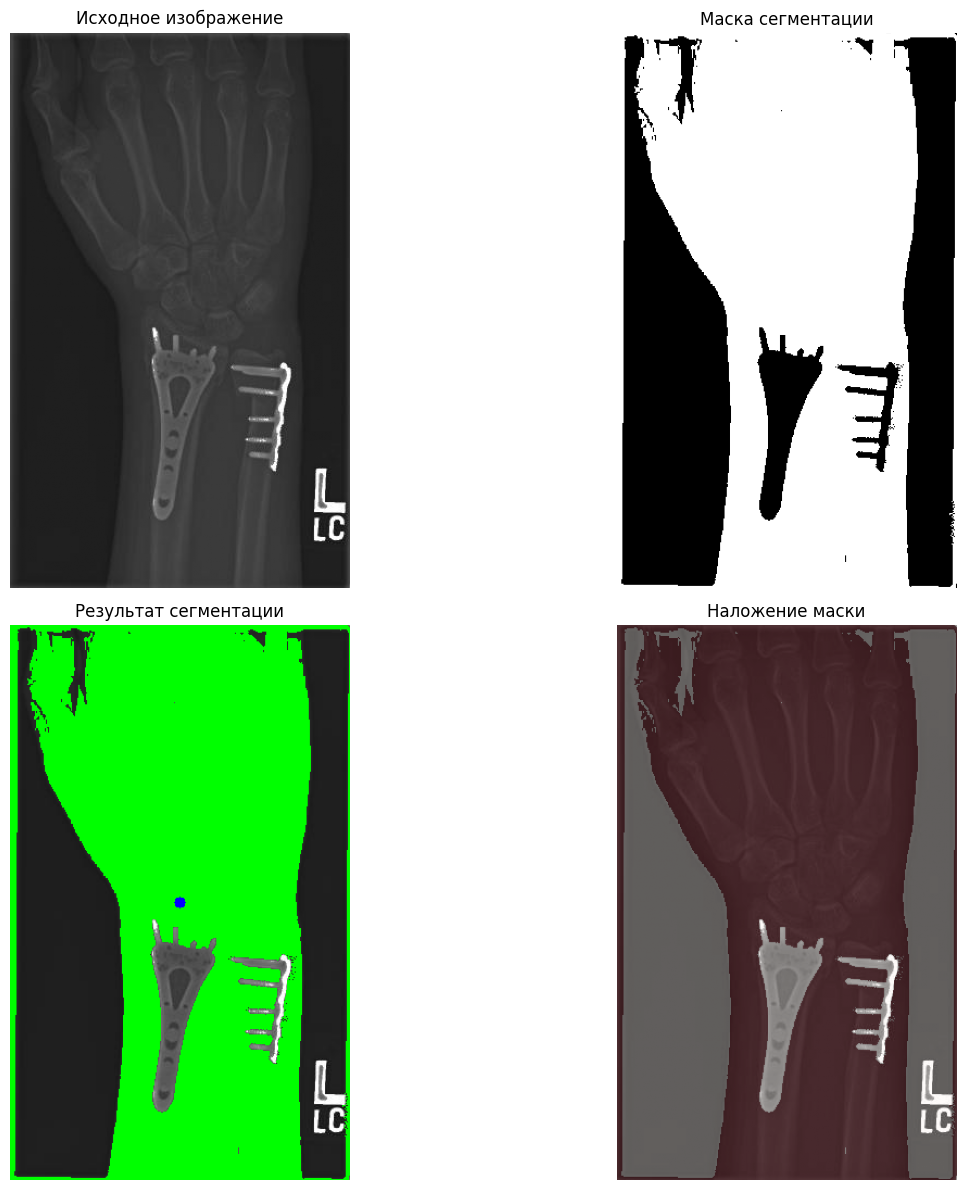


Статистика:
Площадь сегментированной области: 98404 пикселей
Процент от всего изображения: 61.40%


In [66]:
result, seeds = demonstrate_region_growing()

In [162]:
def generate_markers_cv2(gray):

    h, w = gray.shape


    bin_img = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        101,
        -10
    )

    # 2. Удаление мелких шумов и оставление только крупных объектов
    kernel = np.ones((3, 3), np.uint8)
    bin_clean = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
    bin_clean = cv2.morphologyEx(bin_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 3. Найти связные компоненты
    num_labels, labels = cv2.connectedComponents(bin_clean)

    if num_labels <= 1:
        # Нет объектов
        internal_marker = np.zeros((h, w), dtype=np.uint8)
        external_marker = np.zeros((h, w), dtype=np.uint8)
        watershed_marker = np.ones((h, w), dtype=np.int32)  # весь фон
        return internal_marker, external_marker, watershed_marker


    areas = []
    for i in range(1, num_labels):
        area = np.sum(labels == i)
        areas.append((area, i))
    areas.sort(reverse=True)


    _, main_label = areas[0]
    internal_marker = (labels == main_label).astype(np.uint8)

    # 5. Внешний маркер
    dilate1 = cv2.dilate(internal_marker, kernel, iterations=10)   # внутренняя граница кольца
    dilate2 = cv2.dilate(internal_marker, kernel, iterations=30)  # внешняя граница кольца
    external_marker = dilate2 - dilate1
    external_marker = (external_marker > 0).astype(np.uint8)


    watershed_marker = np.zeros((h, w), dtype=np.int32)
    watershed_marker[external_marker == 1] = 1      # фон
    watershed_marker[internal_marker == 1] = 2

    return internal_marker, external_marker, watershed_marker


def segment_plate_watershed(gray):

    # 1. Генерация маркеров
    internal, external, markers = generate_markers_cv2(gray)

    # 2. Цветное изображение для cv2.watershed
    img_color = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # 3. Применяем Watershed
    markers_out = cv2.watershed(img_color, markers.copy())

    # 4. Границы: где markers_out == -1
    boundary = (markers_out == -1).astype(np.uint8)

    plate_mask = (markers_out == 2).astype(np.uint8)

    result = img_color.copy()
    result[boundary == 1] = [0, 0, 255]

    return result, plate_mask, boundary, internal, external, markers_out

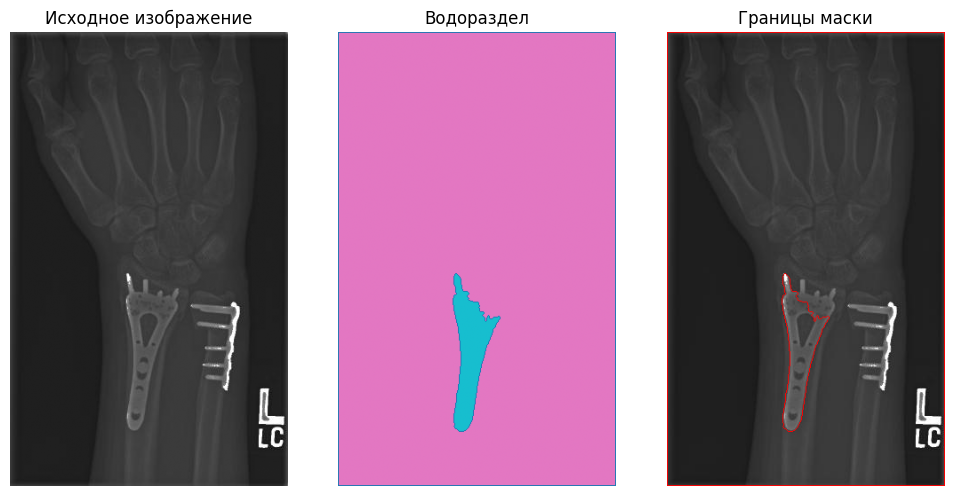

In [164]:
result_img, plate_mask, boundary, internal, external, final_markers = segment_plate_watershed(gray)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(final_markers, cmap='tab10')
plt.title('Водораздел')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title('Границы маски')
plt.axis('off')

plt.tight_layout()
plt.show()